## Importing Library and Dataset

In [69]:
# !pip install shap
# !pip install optuna
# !pip install category_encoders
# !pip install catboost

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency,pointbiserialr
from scipy.stats.contingency import association
import plotly.express as px

## SDA Function

In [71]:
# checking the correlation to the target variable with the chi square.
# if the p-value is under 0.05, the correlation to the target variable is statistically significant.
def check_correlation(df,col,target_col):
  contigency = pd.crosstab(df[col],df[target_col])
  res = chi2_contingency(contigency)
  print(f"{col} - {target_col} : ", 'Correlated 'if res[1] < 0.05  else 'Not Correlated', ',',res[1])

# count probability acceptance to the column.
def probability(df, col):
  yes_man = df.loc[(df['Y'] == 1), col].value_counts()
  value_counts = df[col].value_counts()

  val_index = value_counts.index

  ratio_yes = yes_man / value_counts

  return  val_index, ratio_yes*100

# show the distribution of the column and its probability
def show_dist_prob(df, col):
    idx_occ, prob_occ = probability(df, col)

    occ_val_counts = df[col].value_counts()

    fig = make_subplots(cols=2, rows=1, subplot_titles=['Value Counts', 'Acceptance Probability'], shared_yaxes=True)

    fig.add_trace(
        go.Bar(x=occ_val_counts, y=occ_val_counts.index, orientation='h'),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=prob_occ, y=idx_occ, orientation='h'),
        row=1, col=2
    )

    fig.update_layout(title=col, width=800, height=600)

    fig.show()


# Loading the dataset

In [73]:
df = pd.read_csv('data.csv')
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [76]:
print(df.shape)
df.info()

(12684, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12

In [78]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


# Pre-processing Step

In [81]:
df.duplicated().sum()

74

In [83]:
df = df.drop_duplicates()

In [85]:
df.isna().sum()/len(df)*100

destination              0.000000
passanger                0.000000
weather                  0.000000
temperature              0.000000
time                     0.000000
coupon                   0.000000
expiration               0.000000
gender                   0.000000
age                      0.000000
maritalStatus            0.000000
has_children             0.000000
education                0.000000
occupation               0.000000
income                   0.000000
car                     99.143537
Bar                      0.848533
CoffeeHouse              1.720856
CarryAway                1.189532
RestaurantLessThan20     1.022998
Restaurant20To50         1.498810
toCoupon_GEQ5min         0.000000
toCoupon_GEQ15min        0.000000
toCoupon_GEQ25min        0.000000
direction_same           0.000000
direction_opp            0.000000
Y                        0.000000
dtype: float64

The dataset provides the empty value in car, bar, coffeeHouse, carryAway,  Restaurant20To50 , and RestaurantLessThan20

# Exploratory Data Analysis --->

## Uni-Variate Analysis

### Dependent Variable

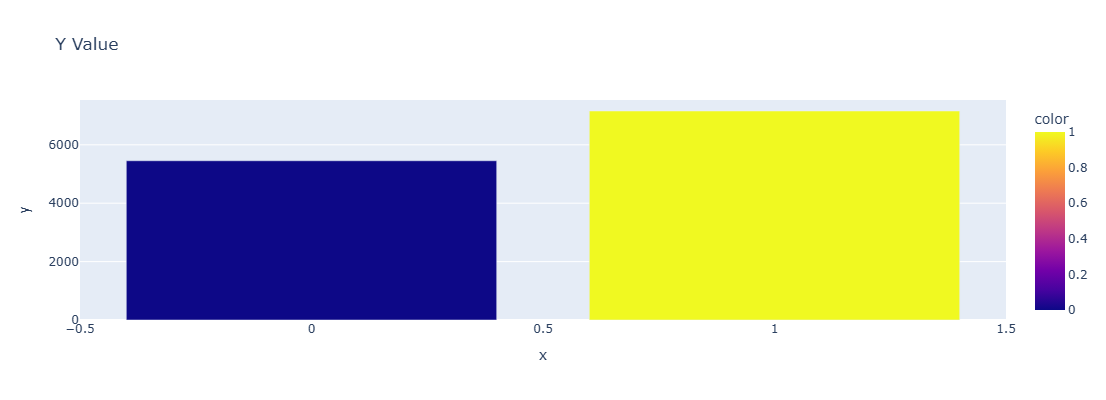

In [100]:
y = df['Y'].value_counts()

px.bar(x = y.index , y = y, title = 'Y Value', width = 600, height = 400, color = y.index)

The frequency of the Y data is unbalanced. However, the imbalance is not severe, so we can either oversample or use the original data to see if the data affects the performance of the model.

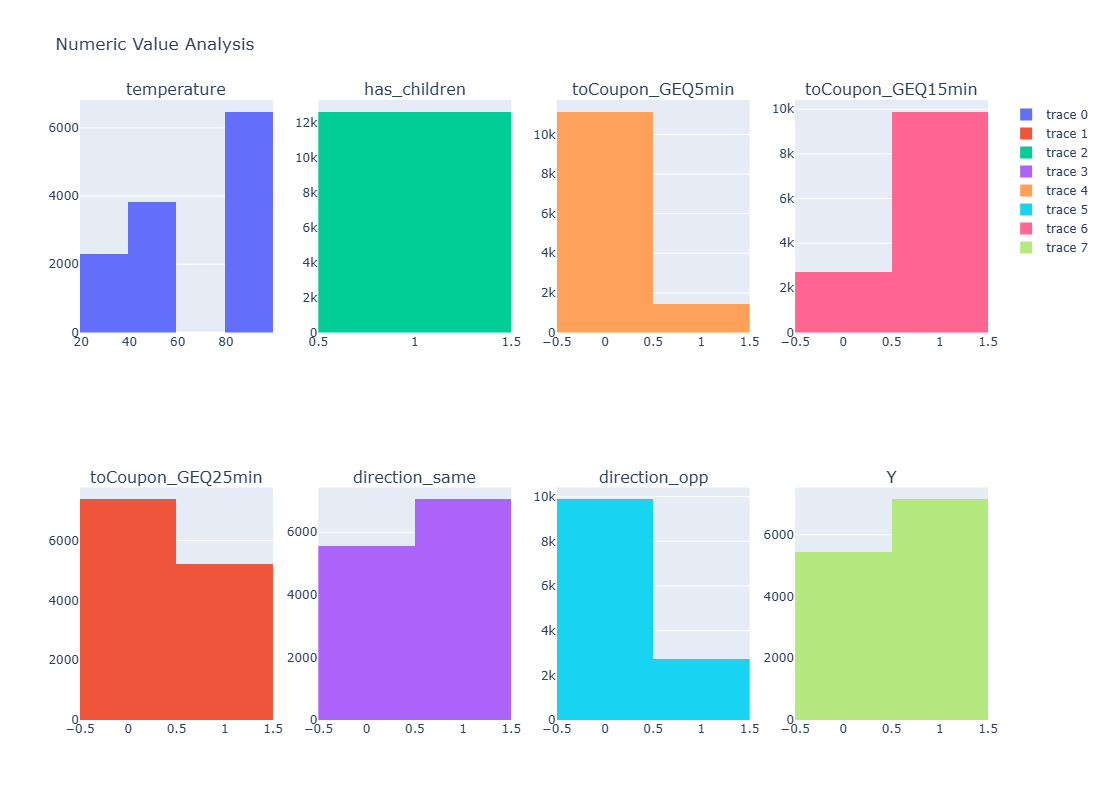

In [102]:
numeric_cols = df.select_dtypes(include = 'number').columns.to_list()
fig = make_subplots(rows= 2 , cols=4, subplot_titles = numeric_cols)

for index,col in enumerate(numeric_cols):
  fig.add_trace(
      go.Histogram(x = df[col]), row = index %2 + 1 , col = index //2 + 1
  )

fig.update_layout(height=800, width=1200, title_text="Numeric Value Analysis")
fig.show()

Most of the numeric value in the dataset have 2 numeric value that consists 1 or 0, except the temperature.

## Bi-Variate Analysis

###  Weather 

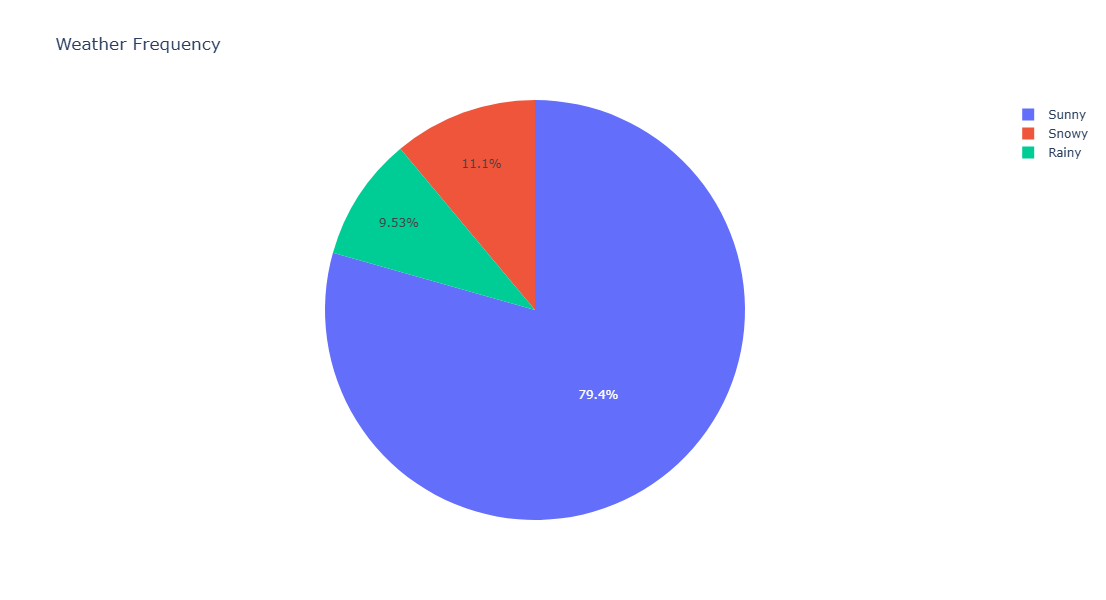

In [108]:
val_counts_weather = df['weather'].value_counts()

val_counts_weather_with_y = df.groupby(['weather','Y']).size().reset_index(name="counts")


px.pie(names = val_counts_weather.index, values = val_counts_weather, title = 'Weather Frequency', width = 800, height = 600)

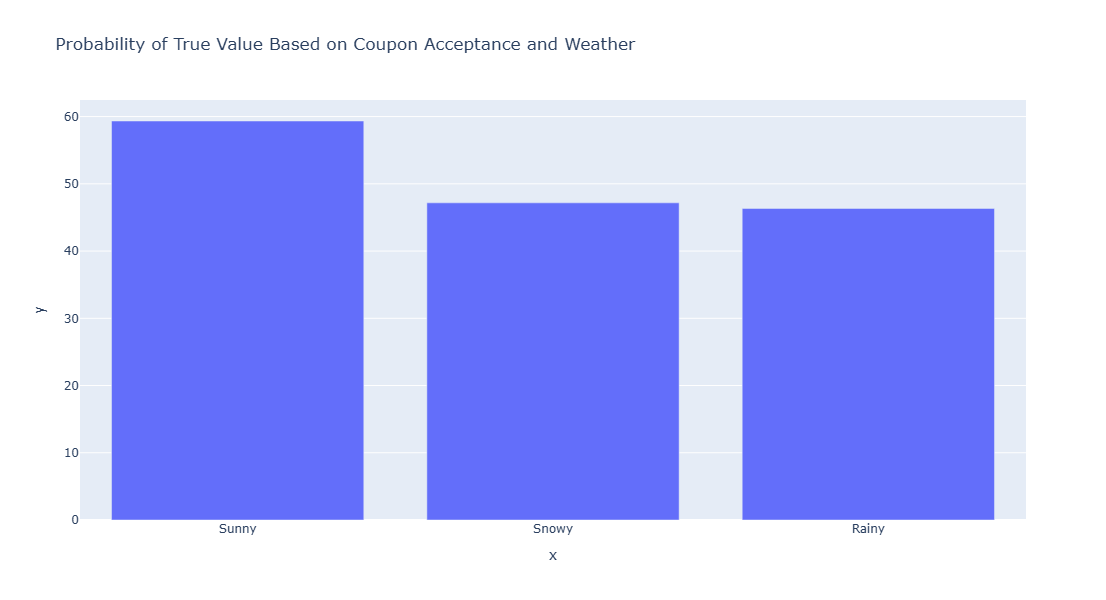

weather - Y :  Correlated  , 1.4913408138835103e-29


In [110]:
index, ratio_weather = probability(df,'weather')

fig = px.bar(x = index , y = ratio_weather , title = 'Probability of True Value Based on Coupon Acceptance and Weather', width = 800, height = 600)
fig.show()
check_correlation(df.copy(),'weather','Y')

The probability of sunny weather to coupon acceptance is 60%. It means, if we give the coupon to on the sunny weather, the acceptance is probably high.

### Same Vs Opposite Direction


Y                  0     1
direction_same            
0               4316  5576
1               1137  1581


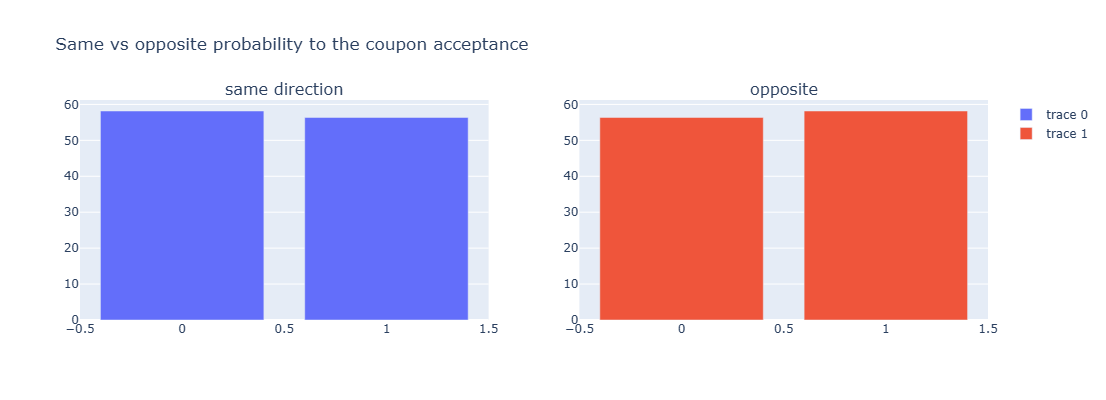

direction_same - Y :  Not Correlated , 0.09794551080620423
direction_opp - Y :  Not Correlated , 0.09794551080620423


In [119]:
fig = make_subplots(rows= 1 , cols= 2, subplot_titles = ['same direction', 'opposite'])

same_idx, same_val = probability(df.copy(),'direction_same')
opp_idx, opp_val = probability(df.copy(),'direction_opp')

print(pd.crosstab(df['direction_same'], df['Y']))

fig.add_trace(
    go.Bar(x = opp_idx, y = opp_val), row = 1 , col = 1
)

fig.add_trace(
    go.Bar(x = same_idx, y = same_val), row = 1, col = 2
)

fig.update_layout(height=400, width=600, title_text="Same vs opposite probability to the coupon acceptance")
fig.show()
check_correlation(df,'direction_same','Y')
check_correlation(df,'direction_opp','Y')

Based on the contigency table and probability analysis, the frequency between same direction and opposite dirrection to the coupon acceptance (Y) is slightly different. In addition, Both of the variable are not statisticaly correlated with the coupon acceptance.

###  Time and Expire Day

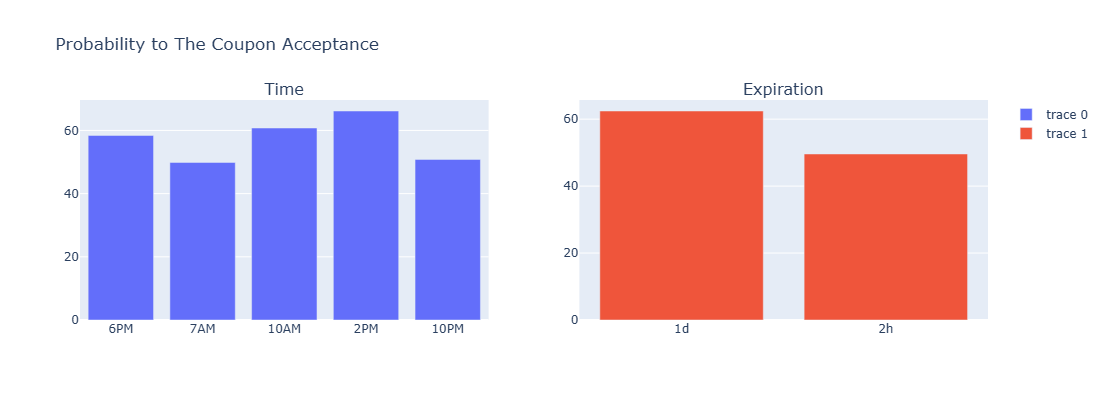

In [122]:
time_idx, time_prob = probability(df.copy(),'time')
expire_idx, expire_prob = probability(df.copy(),'expiration')

fig = make_subplots(rows= 1 , cols= 2, subplot_titles = ['Time', 'Expiration'])

fig.add_trace(
    go.Bar(x = time_idx, y = time_prob), row = 1 , col = 1
)

fig.add_trace(
    go.Bar(x = expire_idx, y = expire_prob), row = 1, col = 2
)

fig.update_layout(height=400, width=600, title_text="Probability to The Coupon Acceptance")
fig.show()

The probability analysis shows that more people accept the voucher at 10:00 am, 6:00 pm, and peak at 2:00 pm. For Expiration, we see that more people accept the coupon when it expires in one day.

In [124]:
check_correlation(df.copy(),'time','Y')
check_correlation(df.copy(),'expiration','Y')

time - Y :  Correlated  , 9.898537330148834e-38
expiration - Y :  Correlated  , 2.967455865355043e-47


We also check the correlation with chi-square and both of the two variables are statistically correlated with coupon acceptance. 

###  Job & income & education 

In [148]:
def income_output(df,li,col):

  temp_df = df[[col,'Y']].copy()
  temp_df['high_acc'] = temp_df[col].apply(lambda x : x in li)

  return temp_df

def descending_withThresh(prob,thresh):
  return prob.sort_values(ascending = False).iloc[:-thresh].index


def get_higher_variable(df,col):
  idx , prob = probability(df,col)
  thresh_result = {'p-value':[],'crammer_v':[]}
  thresh_li = [x for x in range(1,len(prob)+1)]

  desc_result = prob.sort_values(ascending = False)

  for i in thresh_li:
    high_acc = descending_withThresh(desc_result,i)


    df_res = income_output(df.copy(),high_acc,col)

    cont = pd.crosstab(df_res['high_acc'],df_res['Y'])

    correlation = chi2_contingency(cont)[1]
    assoc = association(cont,method = 'cramer')

    thresh_result['p-value'].append(correlation)
    thresh_result['crammer_v'].append(assoc)

  result_df = pd.DataFrame(thresh_result, index = thresh_li)
  result_df = result_df[result_df['p-value'] < 0.01]

  max_thresh_index = result_df[result_df['crammer_v'] == result_df['crammer_v'].max()].index[0]
  max_filtered = descending_withThresh(desc_result,max_thresh_index)

  return result_df , descending_withThresh(desc_result,max_thresh_index),desc_result[max_filtered]


#### Income

In [156]:
show_dist_prob(df,'income')
check_correlation(df,'income','Y')

Based on the probability analysis, we see that the person with the very high income (87500) has the lowest acceptance probability. Otherwise, the person with a medium income (50000 - 62499) has the highest acceptance probability. The correlation with coupon acceptance (Y) seems to be statistically significant, since the chi-square p-value is under 0.05.

In addition, to filter which income has high probability to accept the coupon, we can use the threshold. The threshold is the index that we exclude in the probability series. The final threshold is choosen based on the strength of the correlation (crammer v).

In [154]:
result_df, acc_income, desc_income = get_higher_variable(df,'income')
result_df

In [158]:
desc_income

income
$25000 - $37499     0.159080
$12500 - $24999     0.144726
$37500 - $49999     0.142347
$100000 or More     0.136162
$50000 - $62499     0.131245
Less than $12500    0.081998
Name: proportion, dtype: float64

#### Occupation

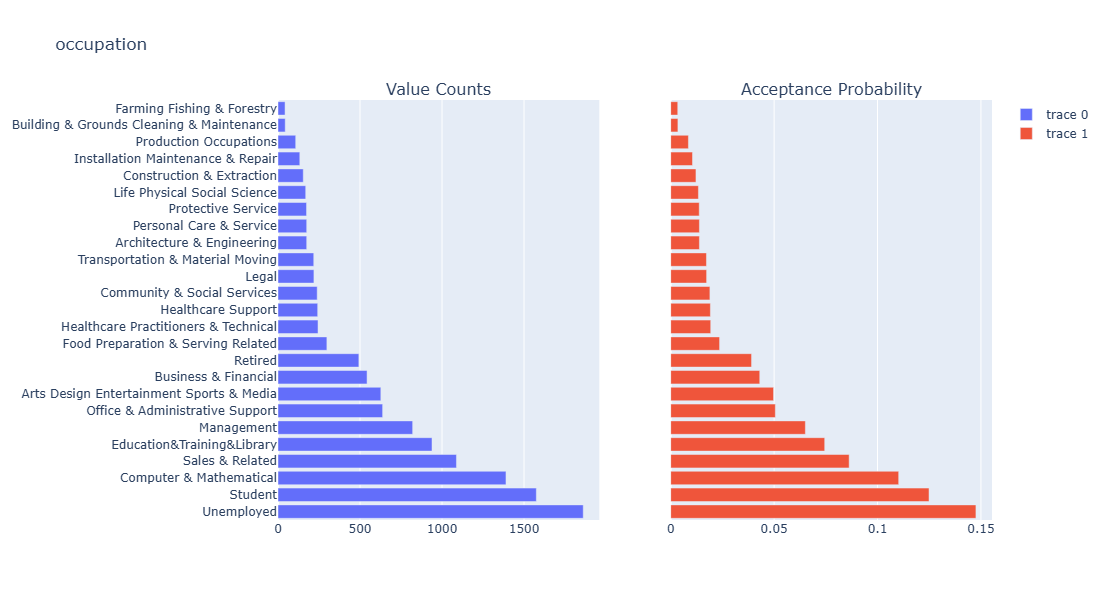

income - Y :  Correlated  , 4.2204009018346824e-08


In [160]:
show_dist_prob(df.copy(),'occupation')
check_correlation(df,'income','Y')

Based on the probability of each job, we see that there are some jobs with high probability of acceptance. The highest acceptance of the voucher goes to health care practitioners and technical. In addition, the p-value of the chisquare is less than 0.05, which indicates that this column is statistically correlated with the acceptance of the coupon. 

However, to easily determine the jobs with high acceptance, we can use the threshold as well as the income columns.

In [164]:
job_df, acc_job, desc_job = get_higher_variable(df,'occupation')
job_df

In [166]:
desc_job

occupation
Unemployed                                  0.147581
Student                                     0.124901
Computer & Mathematical                     0.110230
Sales & Related                             0.086281
Education&Training&Library                  0.074465
Management                                  0.065107
Office & Administrative Support             0.050595
Arts Design Entertainment Sports & Media    0.049722
Business & Financial                        0.043061
Retired                                     0.039096
Name: proportion, dtype: float64

###  Coupon

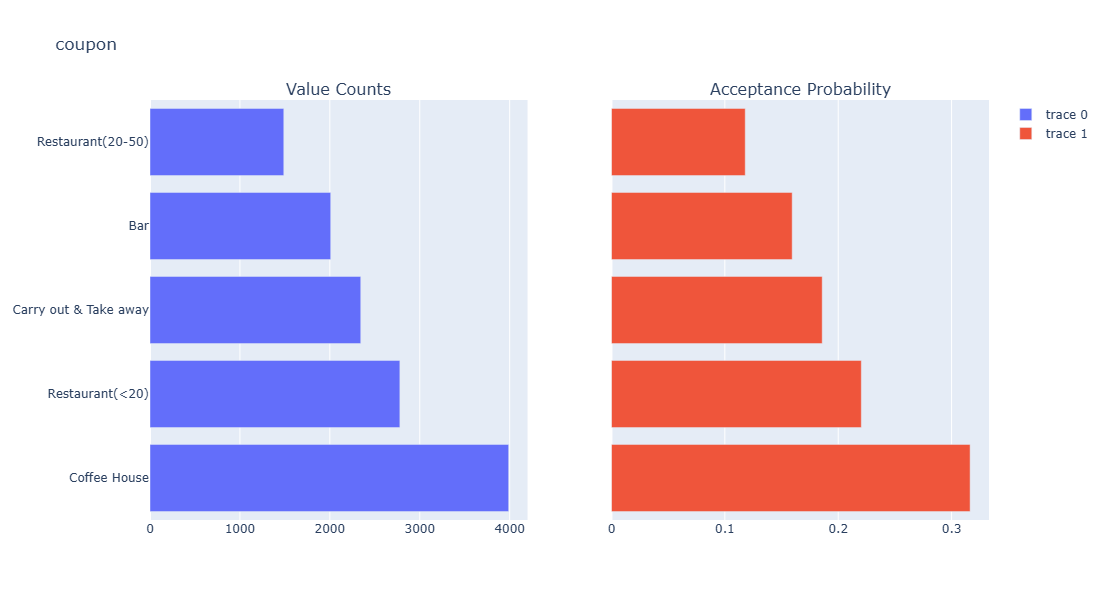

coupon - Y :  Correlated  , 1.2940726343981537e-185


In [169]:
show_dist_prob(df.copy(),'coupon')
check_correlation(df,'coupon','Y')

Based on the probability of acceptance, we see that the restaurant (< 20) and carry out & take away coupons have the highest probability (arround 70%). Moreover, the correlation with the coupon acceptance is statistically correlated because the p-value is below 0.05.

### Other Variable

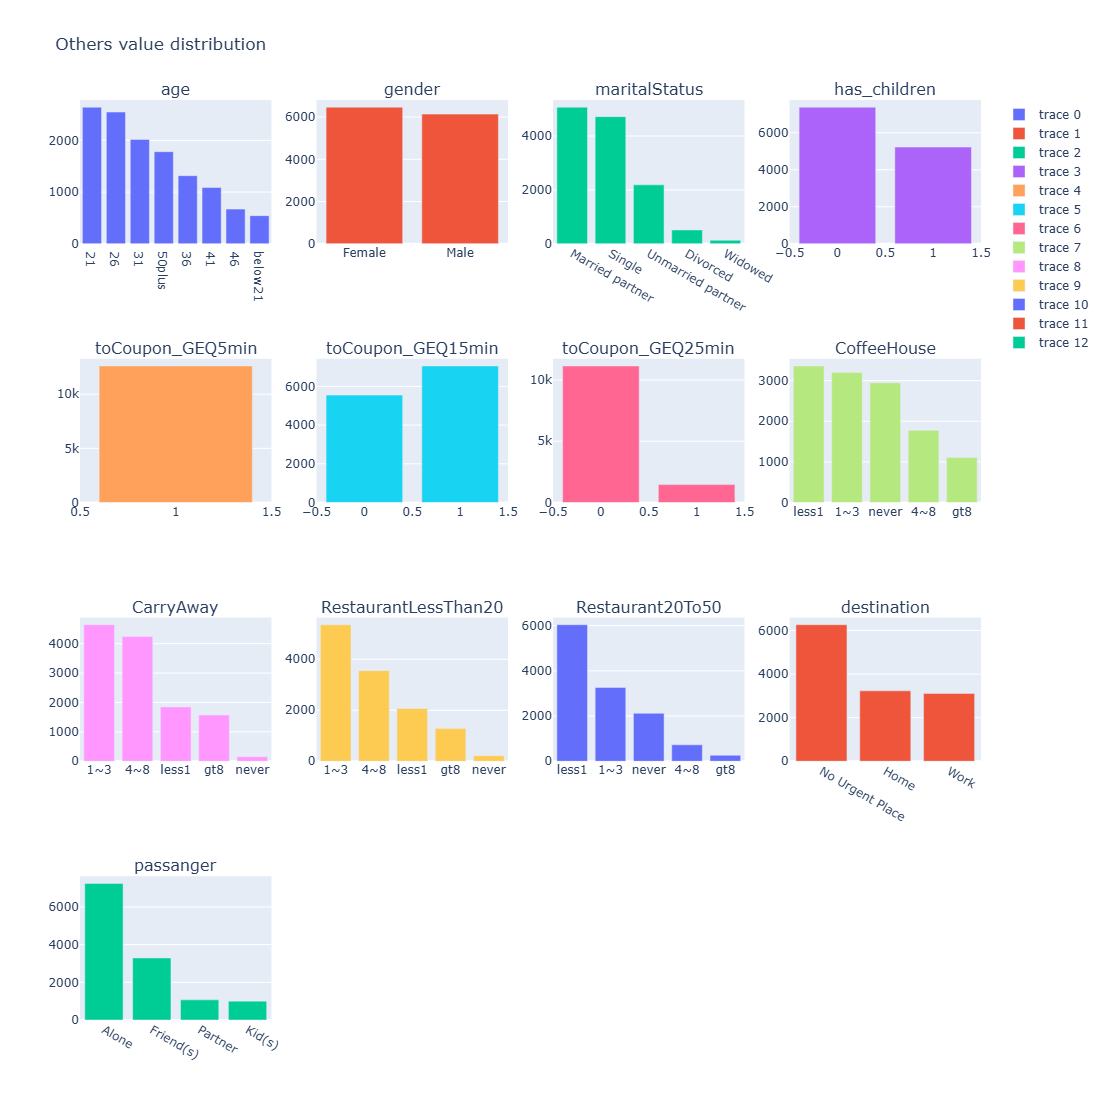

In [171]:
selected_col = ['age','gender','maritalStatus','has_children','toCoupon_GEQ5min','toCoupon_GEQ15min','toCoupon_GEQ25min','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','destination','passanger']
fig = make_subplots(rows = 4, cols = 4, subplot_titles= selected_col)

for idx, col in enumerate(selected_col):
  val_counts = df[col].value_counts()
  fig.add_trace(
      go.Bar(x = val_counts.index, y = val_counts ), row = idx // 4 + 1 , col = idx % 4  + 1
  )

fig.update_layout(width = 1200, height = 1100, title = 'Others value distribution')
fig.show()



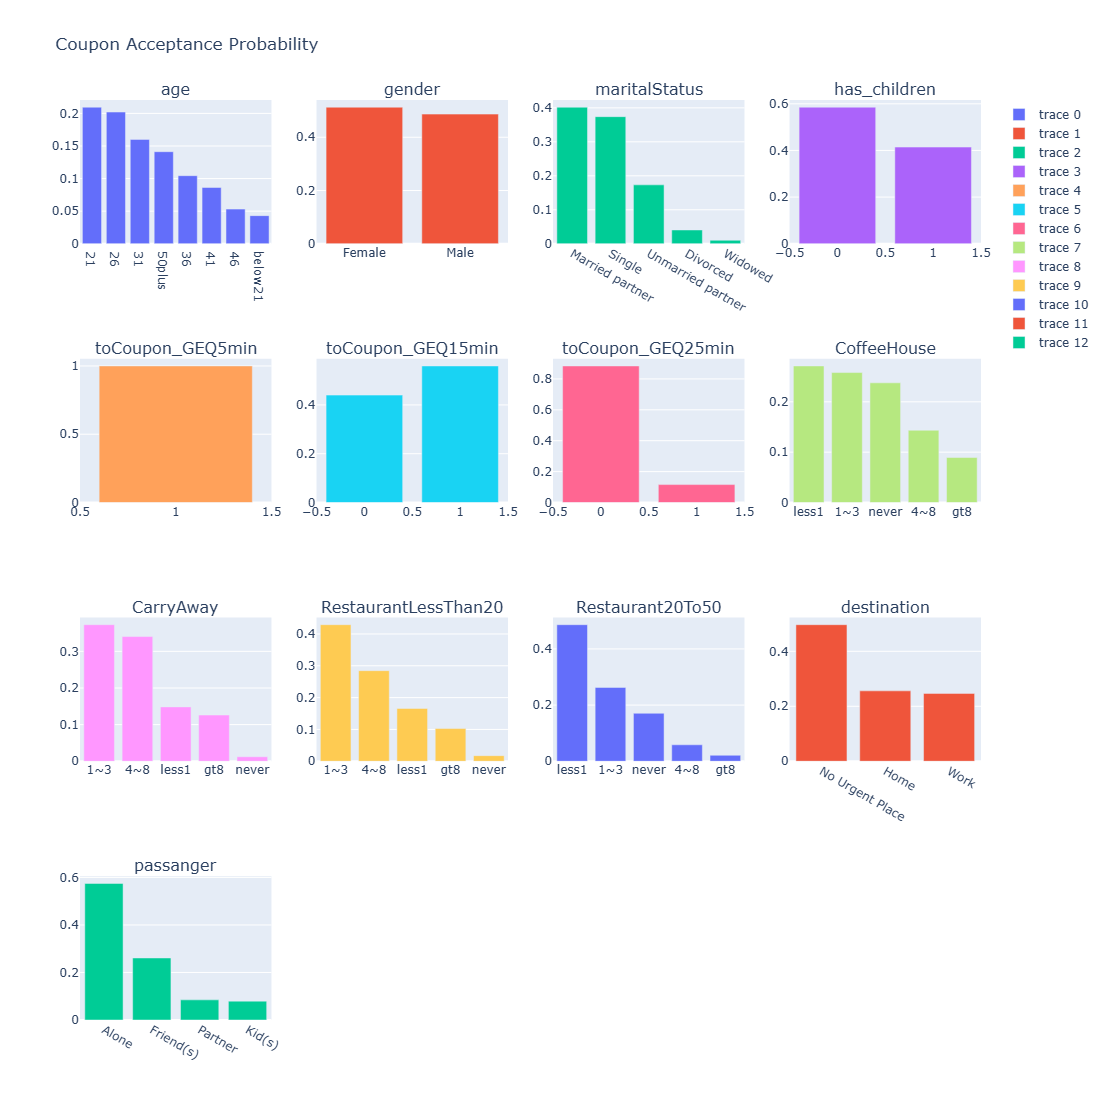

In [173]:
fig = make_subplots(rows = 4, cols = 4, subplot_titles= selected_col)

for idx, col in enumerate(selected_col):
  idx_prob, prob = probability(df,col)
  fig.add_trace(
      go.Bar(x = idx_prob, y = prob ), row = idx // 4 + 1 , col = idx % 4  + 1
  )

fig.update_layout(width = 1200, height = 1100, title = 'Coupon Acceptance Probability')
fig.show()



In [183]:
for col in selected_col :
  check_correlation(df,col,'Y')

age - Y :  Correlated  , 3.25997601211412e-11
gender - Y :  Correlated  , 9.889794644237712e-07
maritalStatus - Y :  Correlated  , 1.1612257960104083e-09
has_children - Y :  Correlated  , 4.6236508293961426e-07
toCoupon_GEQ5min - Y :  Not Correlated , 1.0
toCoupon_GEQ15min - Y :  Correlated  , 1.8998575321790457e-20
toCoupon_GEQ25min - Y :  Correlated  , 8.756836970455762e-34
CoffeeHouse - Y :  Correlated  , 6.306226550010789e-59
CarryAway - Y :  Correlated  , 1.1364375804486557e-08
RestaurantLessThan20 - Y :  Correlated  , 4.758039461993328e-05
Restaurant20To50 - Y :  Correlated  , 5.5026237989170684e-14
destination - Y :  Correlated  , 1.362619213504897e-48
passanger - Y :  Correlated  , 3.086242931837786e-48


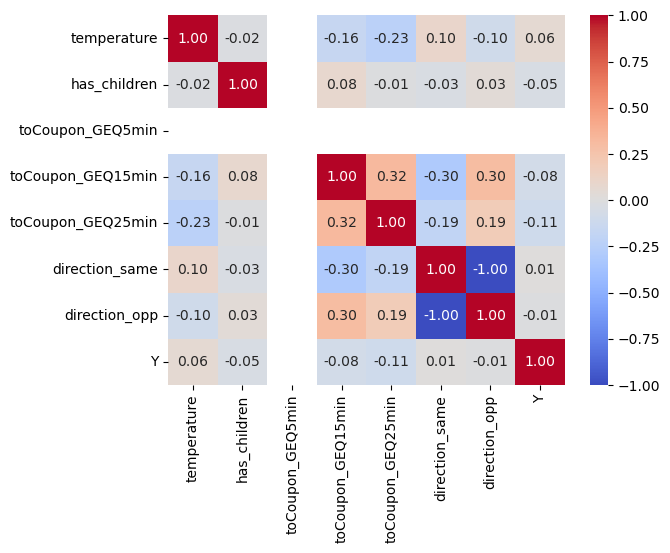

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = df.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()



The column toCoupon_GEQ5min has only one value and does not seem to be correlated with the Y-value. Therefore, we should drop this column.

### Null values

In [185]:
def show_counts_and_null(col):
  print(df[col].value_counts())
  print('Null - value :',df[col].isna().sum(), df[col].isna().sum() * 100/len(df))

null_cols = df.isna().sum()
null_cols = null_cols[null_cols > 0].index
for col in null_cols :
  show_counts_and_null(col)
  print("\n")

car
Scooter and motorcycle                      22
Mazda5                                      22
do not drive                                22
crossover                                   21
Car that is too old to install Onstar :D    21
Name: count, dtype: int64
Null - value : 12502 99.14353687549564


Bar
never    5178
less1    3438
1~3      2468
4~8      1071
gt8       348
Name: count, dtype: int64
Null - value : 107 0.8485329103885805


CoffeeHouse
less1    3362
1~3      3199
never    2946
4~8      1779
gt8      1107
Name: count, dtype: int64
Null - value : 217 1.7208564631245045


CarryAway
1~3      4645
4~8      4242
less1    1849
gt8      1572
never     152
Name: count, dtype: int64
Null - value : 150 1.189532117367169


RestaurantLessThan20
1~3      5356
4~8      3553
less1    2071
gt8      1282
never     219
Name: count, dtype: int64
Null - value : 129 1.0229976209357652


Restaurant20To50
less1    6041
1~3      3266
never    2122
4~8       728
gt8       264
Name: count, dtyp

The car column has 99% null values. Therefore, we should drop the column. 

## Data Preparation

### Drop Irrelevant Variable

In [187]:
droped_column = ['car','toCoupon_GEQ5min','direction_same','direction_opp']
new_df = df.drop(columns = droped_column)

### Split Train & Test Dataset

In [197]:
from sklearn.model_selection import train_test_split

X = new_df.drop(columns = 'Y')
y = new_df.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Filling Null Values

In [199]:
X_train = X_train.fillna('never')
X_test = X_test.fillna('never')

### Category Encoder & Feature Engineering

In [201]:
ordinal_encoder = {
    ('Restaurant20To50', 'RestaurantLessThan20', 'CarryAway', 'Bar', 'CoffeeHouse'): {
        'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5
    },
    'gender': {
        'Male': 1, 'Female': 0
    },
    'expiration': {
        '1d': 1, '2h': 0
    },
    'time': {
        '7AM': 1, '10AM': 2, '2PM': 3, '6PM': 4, '10PM': 5
    },
    'education': {
        'Some High School': 1, 'High School Graduate': 2, 'Some college - no degree': 3,
        'Associates degree': 5, 'Bachelors degree': 6,'Graduate degree (Masters or Doctorate)':7
    },
    'income': {
        'Less than $12500': 1, '$12500 - $24999': 2, '$25000 - $37499': 3, '$37500 - $49999': 4,
        '$50000 - $62499': 5, '$62500 - $74999': 6, '$75000 - $87499': 7, '$87500 - $99999': 8,
        '$100000 or More': 10
    },
    'age': {
        'below21': 1, '21': 2, '26': 3, '31': 4, '36': 5, '41': 6, '46': 6, '50plus': 7
    }
}

encoding_hot_target = ['destination','passanger','weather','maritalStatus','coupon']

for data in [X_train, X_test]:
  data['high_job'] = data['occupation'].apply(lambda x : x in desc_job.index.to_list())
  data['high_income'] = data['income'].apply(lambda x : x in desc_income.index.to_list())

  for col in ordinal_encoder:
    if isinstance(col, tuple):
      for col_spec in col:
        data[col_spec] = data[col_spec].apply(lambda x: ordinal_encoder[col][x])
    else:
      data[col] = data[col].apply(lambda x: ordinal_encoder[col][x])

  summation = data[['Restaurant20To50','RestaurantLessThan20','CarryAway','Bar','CoffeeHouse']].sum(axis = 1, numeric_only = True)

  data['prop_res20'] = data['Restaurant20To50']/summation
  data['prop_resless20'] = data['RestaurantLessThan20']/summation
  data['prop_carry'] = data['CarryAway']/summation
  data['prop_CoffeeHouse'] = data['CoffeeHouse']/summation

  summ_res_bar = data[['Restaurant20To50','RestaurantLessThan20','Bar']].sum(axis = 1, numeric_only = True)
  data['freq_bar_15'] = ( data['toCoupon_GEQ15min'] + 1) / summ_res_bar
  data['freq_bar_25'] = ( data['toCoupon_GEQ25min'] + 1) / summ_res_bar


In [205]:
X_train.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,toCoupon_GEQ15min,toCoupon_GEQ25min,high_job,high_income,prop_res20,prop_resless20,prop_carry,prop_CoffeeHouse,freq_bar_15,freq_bar_25
2874,No Urgent Place,Friend(s),Sunny,80,2,Carry out & Take away,0,0,5,Married partner,...,1,0,True,True,0.214286,0.214286,0.285714,0.214286,0.285714,0.142857
11153,No Urgent Place,Alone,Rainy,55,2,Bar,1,0,6,Married partner,...,1,0,True,False,0.125000,0.187500,0.312500,0.250000,0.285714,0.142857
11863,Work,Alone,Rainy,55,1,Carry out & Take away,1,1,3,Unmarried partner,...,0,0,False,True,0.125000,0.125000,0.375000,0.125000,0.250000,0.250000
8943,Home,Kid(s),Sunny,80,4,Restaurant(20-50),0,0,4,Married partner,...,1,0,True,False,0.153846,0.153846,0.307692,0.307692,0.400000,0.200000
3058,No Urgent Place,Kid(s),Sunny,80,3,Restaurant(<20),1,0,6,Married partner,...,0,0,True,False,0.111111,0.277778,0.222222,0.277778,0.111111,0.111111


In [207]:
def one_hot_encoding(df,col_li):
  one_hot = pd.get_dummies(df[col_li])
  df = pd.concat([df,one_hot],axis = 1)
  df = df.drop(columns = col_li)
  return df

X_train = one_hot_encoding(X_train,encoding_hot_target)
X_test = one_hot_encoding(X_test,encoding_hot_target)

In [209]:
X_train.head()

,temperature,time,expiration,gender,age,has_children,education,occupation,income,Bar,...,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20)
2874,80,2,0,0,5,1,6,Education&Training&Library,5,1,...,False,True,False,False,False,False,True,False,False,False
11153,55,2,1,0,6,1,7,Computer & Mathematical,7,2,...,False,True,False,False,False,True,False,False,False,False
11863,55,1,1,1,3,0,7,Healthcare Practitioners & Technical,3,2,...,False,False,False,True,False,False,True,False,False,False
8943,80,4,0,0,4,1,5,Student,8,1,...,False,True,False,False,False,False,False,False,True,False
3058,80,3,1,0,6,1,7,Computer & Mathematical,7,2,...,False,True,False,False,False,False,False,False,False,True


In [211]:
from category_encoders import MEstimateEncoder

def target_encoding(X_train,X_test,y_train,col):
  encoder = MEstimateEncoder()
  X_train[col] = encoder.fit_transform(X_train[col],y_train)
  X_test[col] = encoder.transform(X_test[col])
  return X_train,X_test

X_train,X_test = target_encoding(X_train,X_test,y_train,'occupation')

In [213]:
X_train.head()

,temperature,time,expiration,gender,age,has_children,education,occupation,income,Bar,...,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,coupon_Bar,coupon_Carry out & Take away,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20)
2874,80,2,0,0,5,1,6,0.528913,5,1,...,False,True,False,False,False,False,True,False,False,False
11153,55,2,1,0,6,1,7,0.571813,7,2,...,False,True,False,False,False,True,False,False,False,False
11863,55,1,1,1,3,0,7,0.666176,3,2,...,False,False,False,True,False,False,True,False,False,False
8943,80,4,0,0,4,1,5,0.618665,8,1,...,False,True,False,False,False,False,False,False,True,False
3058,80,3,1,0,6,1,7,0.571813,7,2,...,False,True,False,False,False,False,False,False,False,True


In [215]:
# renaming columns name

def rename(df):
  map = {
    'passanger_Friend(s)':'passanger_Friends',
    'passanger_Kid(s)' : 'passanger_Kids',
    'coupon_Carry out & Take away' : 'coupon_CarryOut_TakeAway',
    'coupon_Restaurant(<20)':'coupon_Restaurant20'
  }
  return df.rename(columns = map)

X_train = rename(X_train)
X_test = rename(X_test)

In [217]:
X_train.head()

,temperature,time,expiration,gender,age,has_children,education,occupation,income,Bar,...,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,coupon_Bar,coupon_CarryOut_TakeAway,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant20
2874,80,2,0,0,5,1,6,0.528913,5,1,...,False,True,False,False,False,False,True,False,False,False
11153,55,2,1,0,6,1,7,0.571813,7,2,...,False,True,False,False,False,True,False,False,False,False
11863,55,1,1,1,3,0,7,0.666176,3,2,...,False,False,False,True,False,False,True,False,False,False
8943,80,4,0,0,4,1,5,0.618665,8,1,...,False,True,False,False,False,False,False,False,True,False
3058,80,3,1,0,6,1,7,0.571813,7,2,...,False,True,False,False,False,False,False,False,False,True


In [219]:
# setting random variable for feature selection

X_train['rand_int'] = np.random.random(size = len(X_train))
X_test['rand_int'] = np.random.random(size = len(X_test))

In [221]:
X_train.head()

,temperature,time,expiration,gender,age,has_children,education,occupation,income,Bar,...,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,coupon_Bar,coupon_CarryOut_TakeAway,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant20,rand_int
2874,80,2,0,0,5,1,6,0.528913,5,1,...,True,False,False,False,False,True,False,False,False,0.647792
11153,55,2,1,0,6,1,7,0.571813,7,2,...,True,False,False,False,True,False,False,False,False,0.068826
11863,55,1,1,1,3,0,7,0.666176,3,2,...,False,False,True,False,False,True,False,False,False,0.358211
8943,80,4,0,0,4,1,5,0.618665,8,1,...,True,False,False,False,False,False,False,True,False,0.566349
3058,80,3,1,0,6,1,7,0.571813,7,2,...,True,False,False,False,False,False,False,False,True,0.700983


In [223]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_selection import RFECV # Recursive Feature Elimination with Cross-Validation.
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from imblearn.over_sampling import SMOTE
from category_encoders import CatBoostEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,recall_score,precision_score,f1_score,balanced_accuracy_score,roc_auc_score,ConfusionMatrixDisplay


models = {
    'logit':LogisticRegression,
    'decisionTree':DecisionTreeClassifier,
    'randomForest':RandomForestClassifier,
    'GradientBoost':GradientBoostingClassifier,
    'ExtraTrees':ExtraTreesClassifier,
    'LGBM':LGBMClassifier,
    'Xgboost':XGBClassifier,
    'adaboost':AdaBoostClassifier,
    'sgd':SGDClassifier,
    'catboost':CatBoostClassifier,
}



In [227]:
models

{'logit': sklearn.linear_model._logistic.LogisticRegression,
 'decisionTree': sklearn.tree._classes.DecisionTreeClassifier,
 'randomForest': sklearn.ensemble._forest.RandomForestClassifier,
 'GradientBoost': sklearn.ensemble._gb.GradientBoostingClassifier,
 'ExtraTrees': sklearn.ensemble._forest.ExtraTreesClassifier,
 'LGBM': lightgbm.sklearn.LGBMClassifier,
 'Xgboost': xgboost.sklearn.XGBClassifier,
 'adaboost': sklearn.ensemble._weight_boosting.AdaBoostClassifier,
 'sgd': sklearn.linear_model._stochastic_gradient.SGDClassifier,
 'catboost': catboost.core.CatBoostClassifier}

In [229]:
def find_model(models_li,X_train,y_train,X_test,y_test):
  data_frame = {'acc':[],'recall':[],'precision':[],'roc_auc':[]}

  for model_key,model in models_li.items() :
    m = None
    if model_key == 'logit':
       m = make_pipeline(StandardScaler(),model(random_state = 212))
    elif model_key == 'sgd':
      m = make_pipeline(StandardScaler(),model(loss = 'log_loss',random_state = 212))
    else :
      m = model(random_state = 212)

    m.fit(X_train,y_train)
    y_pred = m.predict(X_test)
    y_pred_proba = m.predict_proba(X_test)[:,1]
    data_frame['acc'].append(balanced_accuracy_score(y_test,y_pred))
    data_frame['recall'].append(recall_score(y_test,y_pred))
    data_frame['precision'].append(precision_score(y_test,y_pred))
    data_frame['roc_auc'].append(roc_auc_score(y_test,y_pred_proba))
  return pd.DataFrame(data_frame,index = list(models_li.keys()))

In [231]:
result = find_model(models,X_train,y_train,X_test,y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5741, number of negative: 4347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 10088, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.569092 -> initscore=0.278147
[LightGBM] [Info] Start training from score 0.278147


C:\Users\JoyBoy\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



Learning rate set to 0.027641
0:	learn: 0.6877855	total: 124ms	remaining: 2m 3s
1:	learn: 0.6825064	total: 130ms	remaining: 1m 4s
2:	learn: 0.6775351	total: 138ms	remaining: 45.7s
3:	learn: 0.6731521	total: 145ms	remaining: 36.2s
4:	learn: 0.6691952	total: 155ms	remaining: 30.8s
5:	learn: 0.6648846	total: 162ms	remaining: 26.9s
6:	learn: 0.6617731	total: 168ms	remaining: 23.9s
7:	learn: 0.6579802	total: 175ms	remaining: 21.6s
8:	learn: 0.6544630	total: 181ms	remaining: 19.9s
9:	learn: 0.6513224	total: 187ms	remaining: 18.5s
10:	learn: 0.6478388	total: 193ms	remaining: 17.3s
11:	learn: 0.6445678	total: 199ms	remaining: 16.4s
12:	learn: 0.6413907	total: 205ms	remaining: 15.5s
13:	learn: 0.6390733	total: 212ms	remaining: 14.9s
14:	learn: 0.6360787	total: 218ms	remaining: 14.3s
15:	learn: 0.6336248	total: 225ms	remaining: 13.8s
16:	learn: 0.6312704	total: 231ms	remaining: 13.3s
17:	learn: 0.6291779	total: 237ms	remaining: 12.9s
18:	learn: 0.6266828	total: 243ms	remaining: 12.5s
19:	learn: 

In [233]:
result

,acc,recall,precision,roc_auc
logit,0.659441,0.765537,0.686946,0.724884
decisionTree,0.657611,0.707627,0.697772,0.657611
randomForest,0.724324,0.805791,0.742839,0.805491
GradientBoost,0.704898,0.812147,0.721003,0.771865
ExtraTrees,0.719100,0.781780,0.744452,0.796469
LGBM,0.717824,0.819915,0.732030,0.805696
Xgboost,0.724113,0.800847,0.744094,0.811161
adaboost,0.660388,0.762006,0.688577,0.726698
sgd,0.605052,0.747175,0.640436,0.655434
catboost,0.733561,0.826977,0.746335,0.819964


This trial shows  the Catboost is the best model with the high accuracy, recall, precision and AUC score. So, we select Catboost as a predictor to the test dataset.

### Resampling

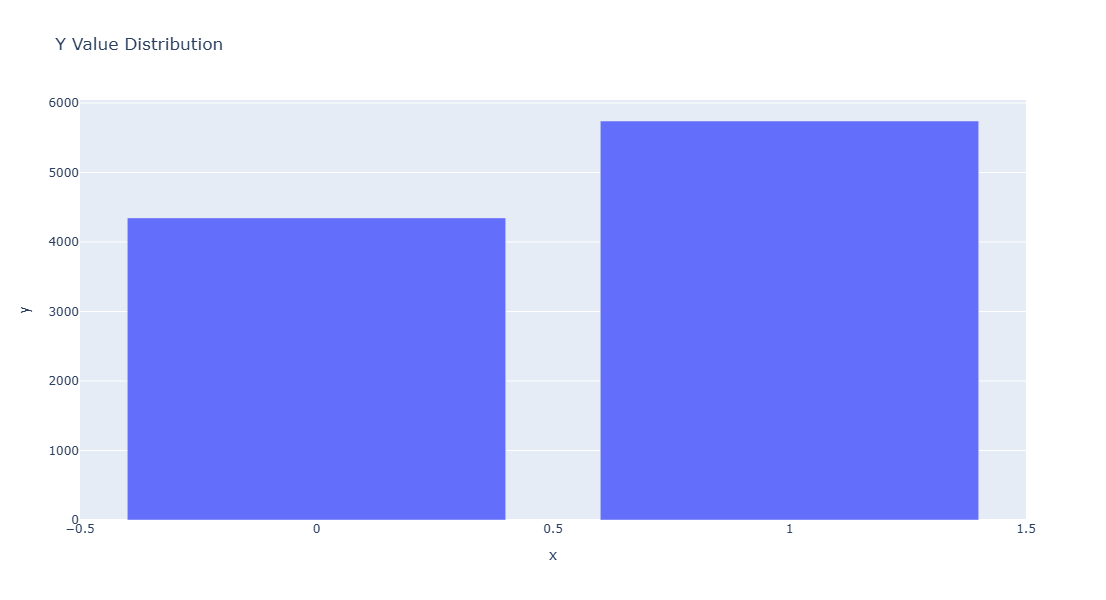

In [239]:
val_counts_y = y_train.value_counts()

px.bar(x = val_counts_y.index , y = val_counts_y, width = 600, height = 600,title = 'Y Value Distribution')

In [257]:
# from imblearn.over_sampling import SMOTE
# r = SMOTE(random_state=42)

# X_train_resample,y_train_resample = r.fit_resample(X_train,y_train)


from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_resample, y_train_resample = ros.fit_resample(X_train, y_train)


### Feature Importance

Let's find which variables have a great impact to the model based on the SHAP value.


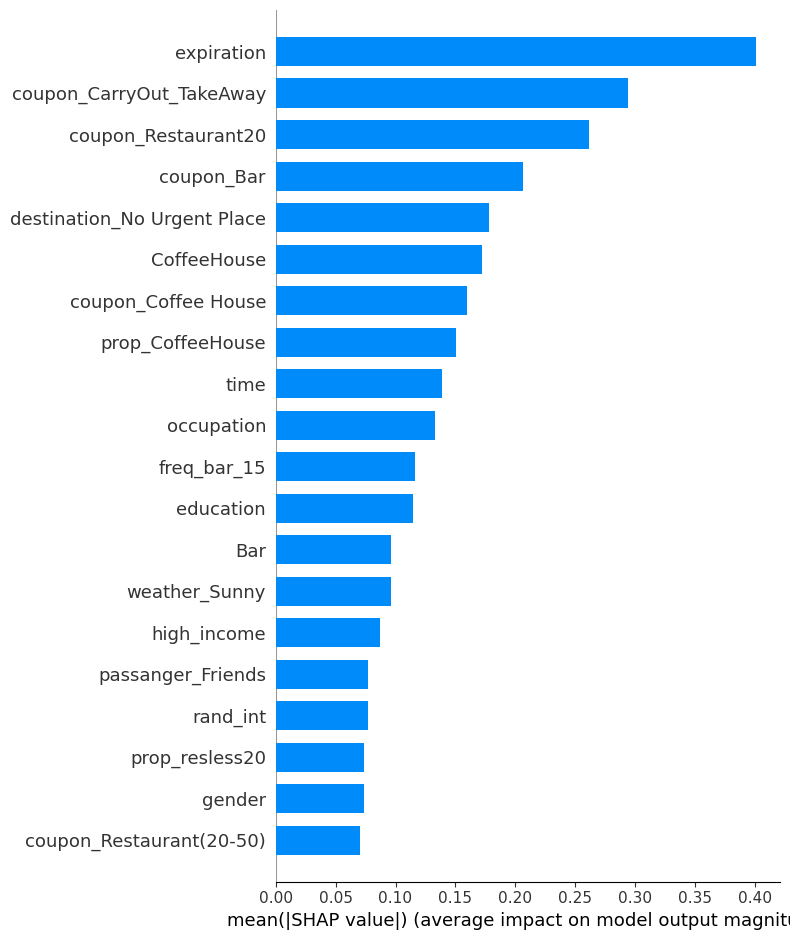

In [261]:
import shap

final_model = models['catboost'](logging_level = 'Silent',random_state =212)
final_model.fit(X_train_resample,y_train_resample)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train_resample)
shap.summary_plot(shap_values, X_train_resample, plot_type='bar')

Based on the summary plot, it shows that expiration , coupon carry out and restaurant coupon less than 20 give the most impact on the model decision.

### Feature selection strategy

To filter any important variables in the model, we can use random variable in the train dataset. So, we calculated the average SHAP value of each column, then we drop the columns which below to the random column SHAP value.

In [263]:
imp_value = pd.Series(np.mean(np.abs(shap_values),axis = 0),index = X_train_resample.columns).sort_values(ascending = False)
imp_value_li = imp_value[imp_value >  imp_value['rand_int']].index.to_list()

In [271]:
final_model = models['catboost'](logging_level = 'Silent',random_state = 212)

X_train_new  = X_train_resample[imp_value_li]
X_test_new = X_test[imp_value_li]

final_model.fit(X_train_new,y_train_resample)

y_pred_train= final_model.predict(X_train_new)

print(classification_report(y_train_resample,y_pred_train))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      5741
           1       0.82      0.84      0.83      5741

    accuracy                           0.83     11482
   macro avg       0.83      0.83      0.83     11482
weighted avg       0.83      0.83      0.83     11482



In [275]:
y_pred= final_model.predict(X_test_new)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1106
           1       0.76      0.76      0.76      1416

    accuracy                           0.73      2522
   macro avg       0.73      0.73      0.73      2522
weighted avg       0.73      0.73      0.73      2522



In [ ]:
## there is 10% of difference between train and test. The model is good but we can do much better with tuning of parameters

This feature selection and resampling works well on the test dataset. The accuracy of the model is increased 1%. 

In [283]:
import optuna

def objective(trial , X_train = X_train_new , y_train = y_train_resample , y_test = y_test, X_test = X_test_new):
  param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]

        ),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
  }

  if param["bootstrap_type"] == "Bayesian":
    param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
    param["subsample"] = trial.suggest_float("subsample", 0.1, 1)


  model = models['catboost'](**param,logging_level = 'Silent',random_state = 212,iterations = 1000)
  model.fit(X_train , y_train)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test , y_pred)
  return acc

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

[I 2024-11-28 23:15:55,802] A new study created in memory with name: no-name-e1723d37-13ba-415f-83e0-e618c14c349b
[I 2024-11-28 23:16:05,539] Trial 0 finished with value: 0.6819984139571769 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07851046098889743, 'depth': 11, 'boosting_type': 'Ordered', 'learning_rate': 0.0068449669911783174, 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 83, 'bagging_temperature': 9.115290141419944}. Best is trial 0 with value: 0.6819984139571769.
[I 2024-11-28 23:16:15,620] Trial 1 finished with value: 0.6812053925455988 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07526074907718965, 'depth': 5, 'boosting_type': 'Ordered', 'learning_rate': 0.009250629235593296, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 52}. Best is trial 0 with value: 0.6819984139571769.
[I 2024-11-28 23:16:20,588] Trial 2 finished with value: 0.6701030927835051 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.047296927048660

numbers of the finished trials: 200
the best params: {'objective': 'Logloss', 'colsample_bylevel': 0.09381890298468308, 'depth': 12, 'boosting_type': 'Plain', 'learning_rate': 0.05925212001132513, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 93}
the best value: 0.7331482950039651


In [299]:
param_rest = {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09130944091779239, 'depth': 11, 'boosting_type': 'Plain', 'learning_rate': 0.08515526764930864, 'bootstrap_type': 'MVS', 'min_data_in_leaf': 100}



final_model_new = models['catboost'](logging_level = 'Silent' ,**param_rest ,random_state = 212, iterations = 1000)

final_model_new.fit(X_train_new,y_train_resample)

y_pred= final_model_new.predict(X_test_new)

print(classification_report(y_test,y_pred))

In [303]:
y_pred_train_new= final_model_new.predict(X_train_new)
print(classification_report(y_train_resample,y_pred_train_new))

The accuracy of the tuned model is improved to 77%. Moreover, the precision score is improved too, indicates the model predicted more true positive value rather than false positive. 

In [305]:
y_pred_proba = final_model.predict_proba(X_test_new)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

cm = confusion_matrix(y_test,y_pred)

fig = px.imshow(cm , x = ['False Positive','True Positive'],y = ['True Negative','False Negative'],
                labels = dict(x = 'Predicted', y = 'True Value'),text_auto=True,width=700, height=500)

fig.update_layout(title = 'Confusion Matrix')

fig2 = px.line(x=fpr, y=tpr,labels=dict(x='False Positive Rate', y='True Positive Rate'),width=700, height=500)

fig2.add_shape(type = 'line', x0 = 0, x1 = 1, y0 = 0, y1 = 1,line = dict(dash = 'dash'))

fig2.update_layout(title = f'Roc Curve ( AUC : {round(roc_auc_score(y_test, y_pred_proba[:,1]),3)} )')

fig.show()
fig2.show()

The model shows good performance on the test dataset. It's shown by the high recall and precision rate, which reduce the amount of false positive and false negative value in the confusion matrix.

In addition, the AUC value is 0.82 and the shape of the curve is above the dashed line. This indicates that this model is a good predictor.